In [1]:
import torch
from tqdm import tqdm
import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
from qna_essentials import QnAClassifier, create_data_loader, eval_model, get_tokenizer, load_custom_dataset
import matplotlib.pyplot as plt

C:\Users\Adam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PRE_TRAINED_MODEL_NAME = 'deepset/gbert-base'
mfaq = load_custom_dataset("clips/mfaq", "de_flat", "validation")
test_data = datasets.load_from_disk('data/bert_bobby_dataset')['test']
tokenizer = get_tokenizer(PRE_TRAINED_MODEL_NAME)
class_names = ['nomatch', 'match']
BATCH_SIZE = 8
MAX_LEN = 512

Found cached dataset mfaq (C:/Users/Adam/.cache/huggingface/datasets/clips___mfaq/de_flat/1.1.0/046d91e0a0390af15e8521190b906d67fd3d4440839559764d1659f48a8dbe7c)
100%|██████████| 2/2 [00:00<00:00,  2.47it/s]
C:\Users\Adam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\datasets\dataset_dict.py:1244: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  FutureWarning,


In [3]:
test_data = test_data.remove_columns(['name', 'sourceName', 'sourceUrl', 'faqLabels'])
test_data

Dataset({
    features: ['answer', 'question', 'matching'],
    num_rows: 702
})

In [4]:
model = QnAClassifier(len(class_names), PRE_TRAINED_MODEL_NAME)
model.load_state_dict(torch.load("models/qna_classifier_2023-10-05.bin"))
#model.load_state_dict(torch.load("../models/qna_classifier_2023-09-08.bin"))
model = model.to(device)

Some weights of the model checkpoint at deepset/gbert-base were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
def get_predictions(model, data_loader):
        model = model.eval()
        questions = []
        answers = []
        predictions = []
        prediction_probs = []
        real_values = []
        with torch.no_grad():
            for d in tqdm(data_loader):
                question_text = d["question_text"]
                answer_text = d["answer_text"]
                input_ids = d["input_ids"].to(device)
                attention_mask = d["attention_mask"].to(device)
                targets = d["targets"].to(device)
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                _, preds = torch.max(outputs, dim=1)
                questions.extend(question_text)
                answers.extend(answer_text)
                predictions.extend(preds)
                prediction_probs.extend(outputs)
                real_values.extend(targets)
        predictions = torch.stack(predictions).cpu()
        prediction_probs = torch.stack(prediction_probs).cpu()
        real_values = torch.stack(real_values).cpu()
        return questions, answers, predictions, prediction_probs, real_values

In [6]:
test_dl = create_data_loader(test_data, tokenizer, MAX_LEN, BATCH_SIZE)
mfaq_dl = create_data_loader(mfaq, tokenizer, MAX_LEN, BATCH_SIZE)
y_questions, y_answers, y_pred, y_pred_probs, y_test = get_predictions(model,test_dl)
#y_questions, y_answers, y_pred, y_pred_probs, y_test = get_predictions(model,mfaq_dl)

100%|██████████| 88/88 [00:35<00:00,  2.48it/s]


In [7]:
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Precision: 0.9186991869918699
Recall: 0.952247191011236
Accuracy: 0.9330484330484331


In [8]:
print(metrics.classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     nomatch       0.95      0.91      0.93       346
       match       0.92      0.95      0.94       356

    accuracy                           0.93       702
   macro avg       0.93      0.93      0.93       702
weighted avg       0.93      0.93      0.93       702



In [9]:
print(metrics.confusion_matrix(y_test, y_pred))
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

[[316  30]
 [ 17 339]]


In [19]:
plt.clf()

<Figure size 640x480 with 0 Axes>

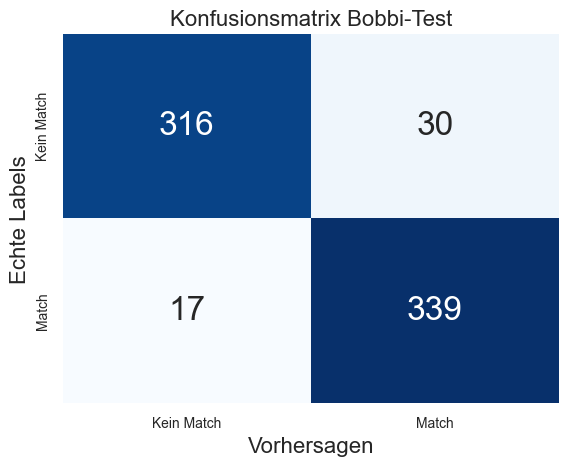

In [24]:
#cm_display = metrics.ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_pred, display_labels=class_names, cmap=plt.cm.Blues, colorbar=False)
import seaborn as sns

ax = plt.subplot()
sns.set(font_scale=2.0) # Adjust to fit
sns.heatmap(confusion_matrix, annot=True, ax=ax, cmap="Blues", fmt="g", cbar=False);  

# Labels, title and ticks
label_font = {'size':'16'}  # Adjust to fit
ax.set_xlabel('Vorausgesagte Labels ', fontdict=label_font);
ax.set_ylabel('Echte Labels', fontdict=label_font);

title_font = {'size':'16'}  # Adjust to fit
ax.set_title('Konfusionsmatrix Bobbi-Test', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=10)  # Adjust to fit
ax.xaxis.set_ticklabels(['Kein Match', 'Match']);
ax.yaxis.set_ticklabels(['Kein Match', 'Match']);
plt.show()
#cm_display.plot()